# Symmetrisierte Daten

Wenn man die Daten auf die ganze reziproke Gitterzelle fortsetzt, kann man das Gradient Descent auch ohne eingebaute Symmetrie verwenden. Dabei kommen deutlich bessere Modelle raus.

In [1]:
import setup
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(precision=3, suppress=True)
from tight_binding_redweasel import *
from tight_binding_redweasel import qespresso_interface as qe
from tight_binding_redweasel import fermi_surface as fs

Symmetries: 48
[12.969+0.j 13.659+0.j 13.841+0.j 14.104+0.j 14.312+0.j 14.545+0.j
 15.913+0.j 16.374+0.j 17.331+0.j 17.566+0.j 18.055+0.j 23.452+0.j
 23.878+0.j 26.123+0.j 28.878+0.j 29.232+0.j]
loss: 1.37e-02 (max band-error [0.017 0.036 0.037 0.019 0.027 0.026 0.028 0.028 0.027 0.029 0.03  0.076
 0.336 0.961 1.435 1.199])


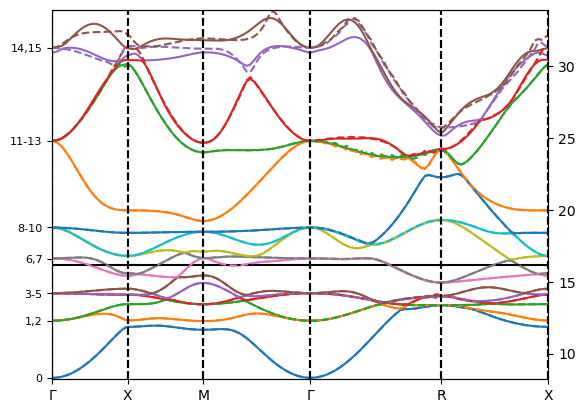

In [11]:
# read the data from Quantum Espresso
material = qe.QECrystal("nitinol_2_993", [], [], [], 0)
k_smpl, _, ref_bands, symmetries, fermi_energy = material.read_bands()
print("Symmetries:", len(symmetries))
ref_bands = ref_bands[:,8:]
k_smpl, ref_bands = Symmetry(symmetries).realize_symmetric_data(k_smpl, ref_bands)

# now start my algorithm to find good matrices
add_bands = 2
band_offset = 0 # = additional bands below reference

weights = np.ones(len(ref_bands[0]))
weights[0] = 0.5
weights[12:] = 0.01

neighbors = ((0, 0, 0), (1, 0, 0), (1, 1, 0), (1, 1, 1)) # works well
neighbors = Symmetry.cubic(True).complete_neighbors(neighbors)

#tb_nitinol = BandStructureModel.init_tight_binding_from_ref(Symmetry.none(), neighbors, k_smpl, ref_bands, band_offset, add_bands, cos_reduced=True, exp=True)
#tb_nitinol = BandStructureModel.load("ni_asym.repr")
tb_nitinol = BandStructureModel.load("asym_nitinol5.json")
#print(tb_nitinol.neighbors)
print(np.diag(tb_nitinol.params[0]))
#tb_nitinol.save("asym_nitinol2.json")
#tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 100, 1, train_k0=True, max_accel_global=2.0)
#tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 100, 1, train_k0=True, max_accel_global=8.0)
#tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 100, 1, train_k0=True, max_accel_global=16.0)
#tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 1000, 32, train_k0=True, regularization=0.999, learning_rate=1.0)

# show error
tb_nitinol.print_error(k_smpl, ref_bands, weights, band_offset)

path = kpaths.KPath('G').to('X').to('M').to('G').to('R').to('X')
interpolator = kpaths.interpolate(k_smpl, ref_bands, Symmetry.none(), method='cubic')
path.plot(tb_nitinol, '-')
path.plot(interpolator, '--', label_bands="left")
#plt.ylim(8, 24)
plt.axhline(fermi_energy, color="k")
plt.show()

In [9]:
k2 = [[1/3,0,0], [2/3,1/3,0]]
print(tb_nitinol.electron_phonon_coupling(k2, [0], [1])[0][:,6:8])
print(tb_nitinol.electron_phonon_coupling(k2, [0], [1])[2][0,0,:,6:8,6:8])

[[15.833 16.331]
 [16.142 16.755]]
[[[-0.073+0.104j  1.542+1.723j]
  [-1.386-0.15j   0.149+0.058j]]

 [[ 0.009-0.012j -0.063-0.071j]
  [ 0.123+0.013j -0.005-0.002j]]

 [[ 0.002-0.002j  0.094+0.104j]
  [ 0.039+0.004j  0.004+0.002j]]]


In [12]:
print("neighbors:", len(tb_nitinol.neighbors))
print("neighbors:", len(tb_nitinol.params))

neighbors: 53
neighbors: 53


In [ ]:
#tb_nitinol.save("ni_asym3.repr")

16.17799823531683


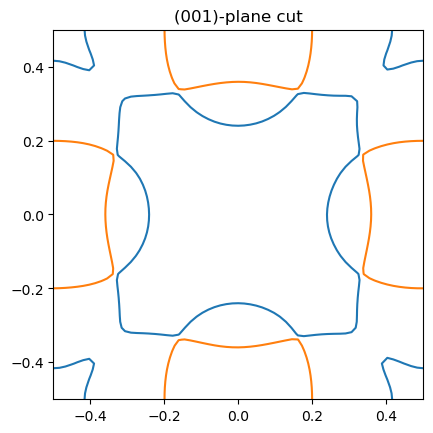

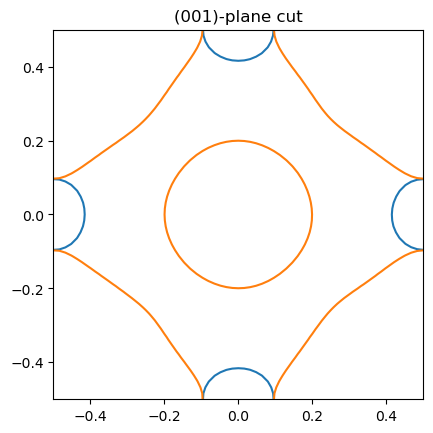

In [12]:
dos_nitinol = dos.DensityOfStates(tb_nitinol, N=20, ranges=((-0.5, 0.5),)*3, wrap=True)
fermi_energy = dos_nitinol.fermi_energy(7)
print(fermi_energy)

fs.plot_2D_fermi_surface(tb_nitinol, fermi_energy, N=63)

Symmetries: 48
k_points: 286
19 bands


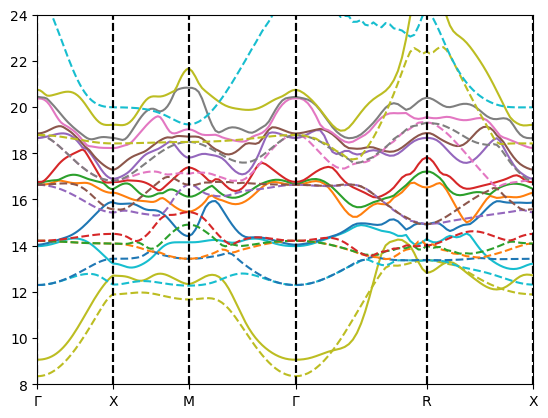

In [ ]:
# read the data from Quantum Espresso
material = qe.QECrystal("nitinol_0K", [], [], [], 0)
k_smpl, _, ref_bands, symmetries, fermi_energy = material.read_bands()
print("Symmetries:", len(symmetries))
print("k_points:", len(k_smpl))
#k_smpl = -k_smpl
k_smpl, ref_bands = Symmetry(symmetries).realize_symmetric_data(np.round(k_smpl, 3), ref_bands)
#print(len(k_smpl))
# read wannier tight binding file
w_neighbors, w_params, w_r_params = material.read_wannier_tb()
#assert len(w_params[0]) == len(ref_bands[0])
print(len(w_params[0]), "bands")
#w_params[0] /= 2

wannier_tb_nitinol = BandStructureModel.init_tight_binding(Symmetry.none(), w_neighbors, len(w_params[0]), cos_reduced=False, exp=True)
wannier_tb_nitinol.set_params_complex(w_params)

path = kpaths.KPath('G').to('X').to('M').to('G').to('R').to('X')
interpolator = kpaths.interpolate(k_smpl, ref_bands, Symmetry.none(), method='cubic')
path.plot(wannier_tb_nitinol, '-')
path.plot(interpolator, '--')
plt.ylim(8, 24)
plt.show()

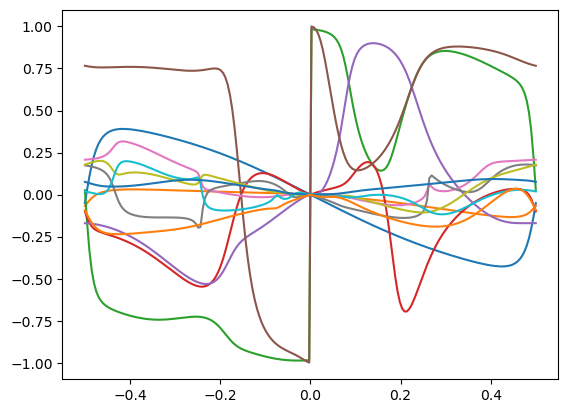

In [ ]:
# plot how the unitary rotation matrices behave by plotting
# a few components of the matrices along a k-line
k_x = np.linspace(-0.5, 0.5, 200)
k_line = k_x[:,None] * np.array([[1, 0, 0]]) + np.array([[1, 1, 1]]) * 0.0
Uk = np.linalg.eigh(tb_nitinol.f(k_line))[1]
for i in range(6):
    plt.plot(k_x, np.abs(Uk[:,0,i]) * np.real(Uk[:,1,i] / Uk[:,0,i]))
    plt.plot(k_x, np.abs(Uk[:,0,i]) * np.real(Uk[:,2,i] / Uk[:,0,i]))
plt.show()

In [ ]:
np.set_printoptions(precision=3, linewidth=1000)
# compute the inversion symmetry transformation at k=0
Uk1 = np.linalg.eigh(tb_nitinol.f([0.0, 0.0, 1e-3]))[1]
Uk2 = np.linalg.eigh(tb_nitinol.f([0.0, 0.0, -1e-3]))[1]
print(np.linalg.eigvals(Uk1 @ np.conj(Uk2.T)))
# compute the 90° x-rotation symmetry transformation at k=0
Uk1 = np.linalg.eigh(tb_nitinol.f([0.0, 0.0, 1e-3]))[1]
Uk2 = np.linalg.eigh(tb_nitinol.f([0.0, 1e-3, 0.0]))[1]
print(np.diag(Uk1 @ np.conj(Uk2.T)))
#print(np.linalg.eigvals(Uk1 @ np.conj(Uk2.T)))
# compute the 90° x-rotation symmetry transformation at k=0
Uk1 = np.linalg.eigh(tb_nitinol.f([1e-3, 1e-3, 1e-3]))[1]
Uk2 = np.linalg.eigh(tb_nitinol.f([1e-3, 1e-3, -1e-3]))[1]
print(np.diag(Uk1 @ np.conj(Uk2.T)))
# compute the 90° x-rotation symmetry transformation at k=0
Uk1 = np.linalg.eigh(tb_nitinol.f([1e-2, 1e-2, 1e-2]))[1]
Uk2 = np.linalg.eigh(tb_nitinol.f([1e-2, -1e-2, 1e-2]))[1]
print(np.diag(Uk1 @ np.conj(Uk2.T)))
# compute the 90° x-rotation symmetry transformation at k=0
Uk1 = np.linalg.eigh(tb_nitinol.f([1e-1, 1e-1, 1e-1]))[1]
Uk2 = np.linalg.eigh(tb_nitinol.f([-1e-1, 1e-1, 1e-1]))[1]
print(np.diag(Uk1 @ np.conj(Uk2.T)))
#np.set_printoptions(precision=1, linewidth=1000)
#print(tb_nitinol.params[1]*100)

[-0.999-0.035j -1.   -0.006j -1.   +0.001j  0.996-0.091j  1.   +0.025j  1.   +0.022j  1.   -0.023j  1.   -0.016j  1.   +0.006j  1.   +0.004j  1.   -0.002j  1.   +0.001j  1.   -0.007j  1.   -0.011j]
[ 1.   +0.j    -0.929+0.371j -0.894+0.448j -0.042+0.999j -0.553-0.833j  0.547-0.837j -0.512-0.859j -0.98 -0.199j  0.546-0.838j  0.768-0.64j   0.244+0.969j -0.219-0.976j  0.847+0.532j  0.998+0.064j]
[ 1.   +0.j     0.99 +0.137j -0.523-0.852j  0.836+0.548j  0.5  +0.865j  0.98 -0.191j  0.998-0.042j -0.919-0.389j -0.911-0.408j  0.854+0.514j -0.744-0.666j -0.06 -0.998j -0.996+0.085j  0.891+0.454j]
[ 0.999+0.j    -0.868+0.485j  0.904+0.413j  0.372+0.904j  0.047-0.946j  0.572-0.736j  0.537-0.75j  -0.926-0.014j  0.342+0.788j  0.78 -0.139j -0.276+0.853j  0.195+0.961j -0.652+0.728j -0.928+0.354j]
[ 0.867+0.j     0.04 -0.172j -0.122+0.085j  0.768-0.188j  0.57 -0.295j  0.207+0.506j  0.081-0.539j -0.446-0.196j -0.468-0.648j -0.388-0.318j  0.216-0.53j   0.898+0.104j -0.636+0.616j  0.128-0.892j]


Symmetries: 48
(53, 16, 16)
loss: 1.10e-02 (max band-error [0.017 0.036 0.037 0.019 0.027 0.026 0.028 0.028 0.027 0.029 0.03  0.076
 0.336 0.961])


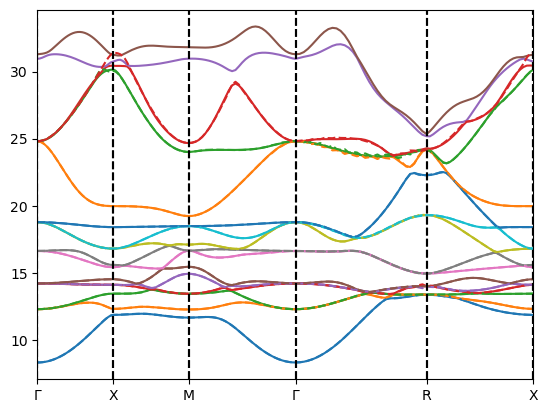

In [3]:
import setup
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(precision=3, suppress=True)
from tight_binding_redweasel import *
from tight_binding_redweasel import qespresso_interface as qe
from tight_binding_redweasel import fermi_surface as fs

# read the data from Quantum Espresso
material = qe.QECrystal("nitinol_2_993", [], [], [], 0)
k_smpl, _, ref_bands, symmetries, fermi_energy = material.read_bands()
print("Symmetries:", len(symmetries))
ref_bands = ref_bands[:,8:-2]
k_smpl, ref_bands = Symmetry(symmetries).realize_symmetric_data(k_smpl, ref_bands)

band_offset = 0

weights = np.ones(len(ref_bands[0]))
weights[0] = 0.5 # lowest band can have less precision
weights[12:] = 0.01 # use 12 bands, use the rest just as "inspiration"

neighbors = ((0, 0, 0), (1, 0, 0), (1, 1, 0), (1, 1, 1))
neighbors = Symmetry.cubic(True).complete_neighbors(neighbors)

#tb_nitinol = AsymTightBindingModel.init_from_ref(neighbors, k_smpl, ref_bands)
tb_nitinol = AsymTightBindingModel.load("asym_nitinol5.json")
#tb_nitinol = AsymTightBindingModel.load("soft_sym_nitinol2.json")
print(tb_nitinol.H.H_r.shape)
#tb_nitinol = AsymTightBindingModel.load("bruinsma_improved.json")
#tb_nitinol.S = HermitianFourierSeries.unit_matrix(tb_nitinol.H.neighbors, len(tb_nitinol.H.H_r[0]))
# add a tiny bit of acceleration to break patterns that might occur
#tb_nitinol.optimize_cg(k_smpl, ref_bands, weights, band_offset, 100, train_S=False)
#tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 100, 1, learning_rate=1.0, train_S=False, max_accel_global=1.0)
#tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 100, 1, max_accel_global=16.0)
#tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 100, 1, max_accel_global=64.0)
#tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 1000, 32, regularization=0.999, learning_rate=1.0)

# show error
tb_nitinol.print_error(k_smpl, ref_bands, weights, band_offset)

path = kpaths.KPath('G').to('X').to('M').to('G').to('R').to('X')
interpolator = kpaths.interpolate(k_smpl, ref_bands, Symmetry.none(), method='cubic')
path.plot(tb_nitinol, '-')
path.plot(interpolator, '--')
#plt.ylim(8, 24)
plt.show()

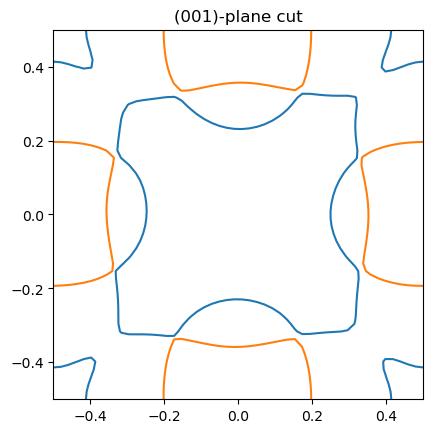

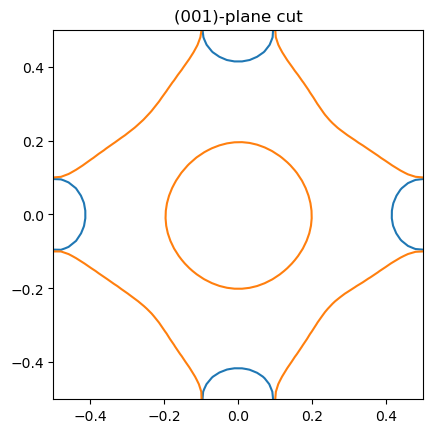

In [8]:
fs.plot_2D_fermi_surface(tb_nitinol, fermi_energy)#, k_range=[-1, 1])

In [5]:
tb_nitinol.save("asym_nitinol5.json")

Now do the same for copper, which has a different cell shape, but again cubic symmetry.

In [1]:
import setup
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(precision=3, suppress=True)
from tight_binding_redweasel import *
from tight_binding_redweasel import qespresso_interface as qe
from tight_binding_redweasel import fermi_surface as fs

In [4]:
# read the data from Quantum Espresso
from tight_binding_redweasel import qespresso_interface as qe
material = qe.QECrystal("cu", [], [], [], 0)
k_smpl, _, ref_bands, symmetries, fermi_energy = material.read_bands()
print("Symmetries:", len(symmetries))
k_smpl, ref_bands = Symmetry.cubic(True).realize_symmetric_data(k_smpl, ref_bands)

np.set_printoptions(precision=3, suppress=True)

# now start my algorithm to find good matrices
#add_bands = 3
#band_offset = 1 # = additional bands below reference
add_bands = 1
band_offset = 0

weights = np.ones(len(ref_bands[0]))
#weights[0] = 0.1
weights[5] = 3
weights[-1] = 0.1
#weights[-2] = 0.1

basis_transform = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]]) / 2.0
neighbors = ((0, 0, 0), (1, 0, 0), (1, 1, 0), (1, 1, 1))
neighbors = np.array(neighbors) @ basis_transform
neighbors = Symmetry.cubic(True).complete_neighbors(neighbors) # this can be done before or after the basis_transform is applied for different results
print("neighbors count", len(neighbors))
#print(np.array(neighbors))

#tb_cu = BandStructureModel.init_tight_binding_from_ref(Symmetry.none(), neighbors, k_smpl, ref_bands, band_offset, add_bands, cos_reduced=True)
#tb_cu.optimize(k_smpl, 1, ref_bands, weights, band_offset, 10, 1, train_k0=True, max_accel_global=1.0)
#tb_cu.optimize(k_smpl, 1, ref_bands, weights, band_offset, 200, 1, train_k0=True, max_accel_global=8.0)

tb_cu = AsymTightBindingModel.new(neighbors, len(ref_bands[0]) + add_bands)
tb_cu.randomize(0.01)
tb_cu.optimize_cg(k_smpl, ref_bands, weights, band_offset, 100)

path = kpaths.KPath('G').to('X2').to('W').to('L').to('G').to('K')
path2 = kpaths.KPath('G').to('X2', 9).to('W', 9).to('L', 9).to('G', 9).to('K', 9*3)
interpolator = kpaths.interpolate_unstructured(k_smpl, ref_bands, Symmetry.none())
path.plot(tb_cu, '-')
plt.axhline(fermi_energy, color='r')
path2.plot(interpolator, '.', band_offset=band_offset)
plt.ylim(5, 25)
plt.show()

Symmetries: 48
neighbors count 23
100: loss 2.72e-01 3.8e+00×[▁▁▁▁▁▁▂█]

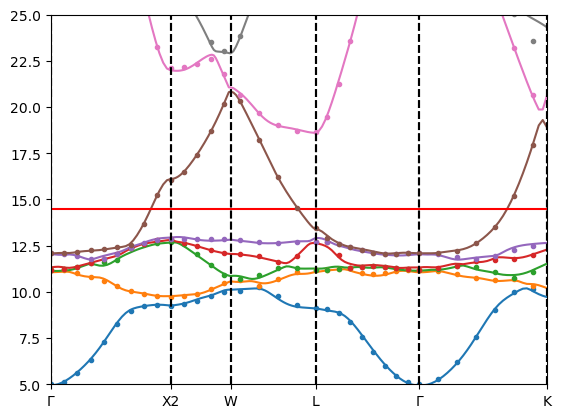

In [5]:
path = kpaths.KPath('G').to('X2').to('W').to('L').to('G').to('K')
path2 = kpaths.KPath('G').to('X2', 9).to('W', 9).to('L', 9).to('G', 9).to('K', 9*3)
interpolator = kpaths.interpolate_unstructured(k_smpl, ref_bands, Symmetry.none())
path.plot(tb_cu, '-')
plt.axhline(fermi_energy, color='r')
path2.plot(interpolator, '.', band_offset=band_offset)
plt.ylim(5, 25)
plt.show()

In [7]:
tb_cu.save("asym_cu2.json")

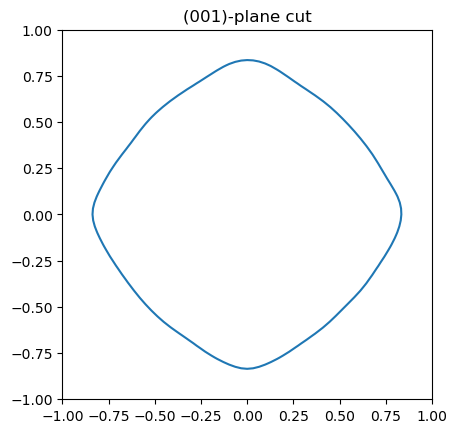

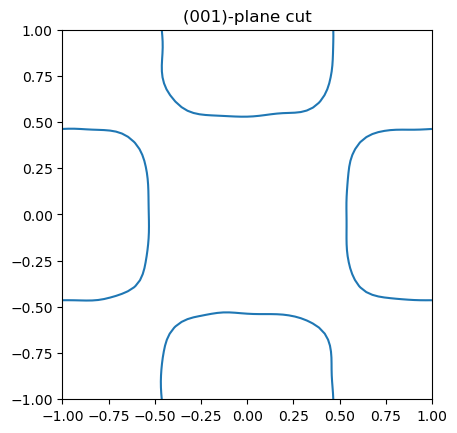

In [6]:
fs.plot_2D_fermi_surface(tb_cu, fermi_energy, N=63, k_range=[-1, 1])